In this notebook, your task is examine the inner workings of the sleep stage classification model you have been creating for the [Haaglanden Medisch Centrum Sleep Staging Database](https://physionet.org/content/hmc-sleep-staging/1.1/).


# Instructions

There are two ways you can complete this assignment:
1. **Modify HW3-3:** Make a copy of your HW3-3 submission and rename it so that it is clear you are submitting a new file. Copy the cells below to the end of that file and complete them once you have modified your original code.
2. **Use this file:** Copy all of the necessary cells from HW3-3 into the beginning of this file.

# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install opencv-python
!pip install scikit-learn
!pip install shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn
import shap

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 13.7 MB/s eta 0:00:00


In [2]:
import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings
def colab2pdf():
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
    NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))
    TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)
    NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=30)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]
    warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)
    with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)
    if not pathlib.Path("/usr/local/bin/quarto").exists():
        !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet
    with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)
    !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
    google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))

# My Refined Model

In [3]:
df = pd.read_csv('psg_data.csv')

In [4]:
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from imblearn.over_sampling import SMOTE

# Set the random seed to an arbitrary number of your choosing
np.random.seed(42)

# Get the features, labels, and grouping variables
x = df.drop(['Subject ID', 'Start Time', 'Annotation'], axis=1).values
y = df['Annotation'].values
groups = df['Subject ID'].values

# Initialize a data structure to save our final results,
# assuming all of the predictions are empty to start
y_pred = np.empty(y.shape, dtype=object)

# Split the data into folds
loocv = LeaveOneGroupOut()
for train_idxs, test_idxs in loocv.split(x, y, groups):
    # Split the data into train and test
    x_train = x[train_idxs]
    y_train = y[train_idxs]
    x_test = x[test_idxs]
    y_test = y[test_idxs]

    # Balance the training dataset
    oversample = SMOTE()
    x_train, y_train = oversample.fit_resample(x_train, y_train)

    # Select the most useful features
    feat_select = SelectPercentile(f_classif, percentile=50)
    feat_select.fit(x_train, y_train)
    x_train = feat_select.transform(x_train)
    x_test = feat_select.transform(x_test)

    # Perform a hyperparameter search
    param_grid = {'n_estimators': [25, 50, 100, 200],
                  'criterion' : ['gini', 'entropy', 'log_loss'],
                  'max_depth': [2, 5, 10, None]}
    clf = RandomForestClassifier(random_state=42)
    grid_search_clf = GridSearchCV(clf, param_grid, cv=5)
    grid_search_clf.fit(x_train, y_train)

    # Predict on the transformed test data
    y_test_pred = grid_search_clf.predict(x_test)
    y_pred[test_idxs] = y_test_pred

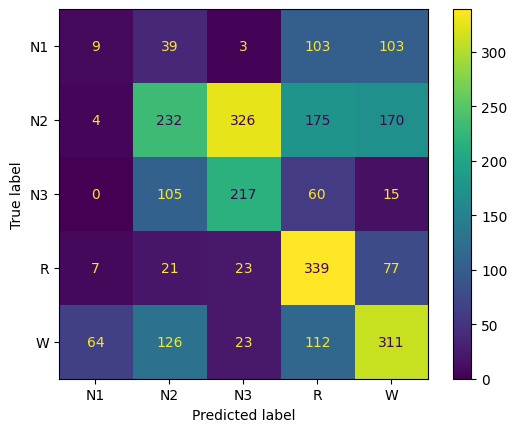

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
classes = np.unique(y_pred)
ConfusionMatrixDisplay.from_predictions(y, y_pred,
                                        display_labels=classes)
plt.show()

In [6]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y, y_pred)}')

Accuracy: 0.4159159159159159


# Exercise 1: Overall Feature Importance

This exercise assumes that you are using a model that is able to report some form of feature importance (e.g., `.coef_`, `.feature_importances_`). If not, please switch to one for the sake of this exercise.

**(Part 1)** Since you are training one model per fold, it is likely that different features are going to be important for different folds. With that in mind, modify your training loop so that you aggregate the feature importance scores across all folds of the cross-validation procedure. The `DataFrame` should looks something like the following:

| Fold # | Feature 1 | Feature 2 | ... |
| ------- | ------- | ------- | ------- |
| 1 | 0.01 | 0.04 | ... |
| 2 | 0.01 | 0.05 | ... |
| 3 | 0.04 | 0.02 | ... |
| ... | ... | ... | ... |

*Hint:* If you are using some form of feature selection, you may want to investigate the `.get_support()` method for identifying the indeces of the features that were selected in a given fold. This also means that your `DataFrame` may have missing entries:

| Fold # | Feature 1 | Feature 2 | ... |
| ------- | ------- | ------- | ------- |
| 1 | 0.01 | 0.04 | ... |
| 2 | 0.01 | NA | ... |
| 3 | NA | 0.02 | ... |
| ... | ... | ... | ... |

In these cases, you should fill in the missing values with `0` to indicate no importance.

In [7]:
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from imblearn.over_sampling import SMOTE

# Set the random seed to an arbitrary number of your choosing
np.random.seed(42)

# Get the features, labels, and grouping variables
x = df.drop(['Subject ID', 'Start Time', 'Annotation'], axis=1).values
y = df['Annotation'].values
groups = df['Subject ID'].values

# Get the original feature names
feature_names = df.drop(['Subject ID', 'Start Time', 'Annotation'], axis=1).columns

# Initialize a data structure to save our final results,
# assuming all of the predictions are empty to start
y_pred = np.empty(y.shape, dtype=object)

# Initialize a data structure for keeping track of feature
# importance scores
feature_importances = []

# Split the data into folds
loocv = LeaveOneGroupOut()
for train_idxs, test_idxs in loocv.split(x, y, groups):
    # Split the data into train and test
    x_train = x[train_idxs]
    y_train = y[train_idxs]
    x_test = x[test_idxs]
    y_test = y[test_idxs]

    # Balance the training dataset
    oversample = SMOTE()
    x_train, y_train = oversample.fit_resample(x_train, y_train)

    # Select the most useful features
    feat_select = SelectPercentile(f_classif, percentile=50)
    feat_select.fit(x_train, y_train)
    x_train = feat_select.transform(x_train)
    x_test = feat_select.transform(x_test)

    # Perform a hyperparameter search
    param_grid = {'n_estimators': [25, 50, 100, 200],
                  'criterion' : ['gini', 'entropy', 'log_loss'],
                  'max_depth': [2, 5, 10, None]}
    clf = RandomForestClassifier(random_state=42)
    grid_search_clf = GridSearchCV(clf, param_grid, cv=5)
    grid_search_clf.fit(x_train, y_train)

    # Predict on the transformed test data
    y_test_pred = grid_search_clf.predict(x_test)
    y_pred[test_idxs] = y_test_pred

    # NEW: Add feature importance data
    # Note: I'm doing a bit of extra work here to account for excluded features
    selected_feature_names = feature_names[feat_select.get_support()]
    selected_feature_scores = grid_search_clf.best_estimator_.feature_importances_
    feature_importance_dict = dict(zip(selected_feature_names,
                                       selected_feature_scores))
    for feature_name in feature_names:
        if feature_name not in selected_feature_names:
            feature_importance_dict[feature_name] = 0
    feature_importances.append(feature_importance_dict)

feature_importance_df = pd.DataFrame(feature_importances)

**(Part 2)** Plot the overall importance of the features in your modeling pipeline as a box-and-whiskers plot. Each box should correspond to a feature, and the distribution should represent the distribution of that feature's importance scores across all folds.

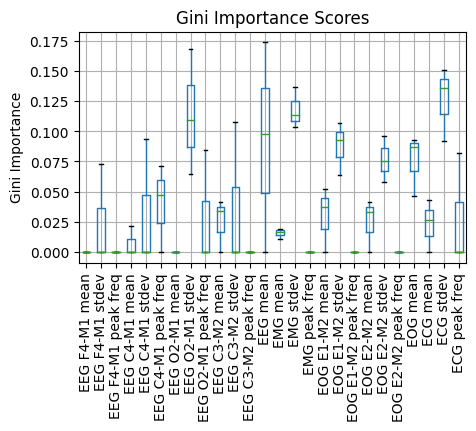

In [8]:
plt.figure(figsize=(5, 3))
feature_importance_df.boxplot(column=list(feature_names))
plt.xticks(rotation = 90)
plt.title('Gini Importance Scores')
plt.ylabel('Gini Importance')
plt.show()

**(Part 3)** What did you learn about your modeling pipeline from this exercise? Were there any features that were consistently important across folds?

Write your answer here:
* It seems like features related to variance were more useful tthan features related to averages. For example, `EEG O2-M1 stdev`, `ECG stdev`, and `EMG stdev` were used in all models and tended to have high importance.
* `EEG mean` had varied importance across all of the models. It was the most important feature in at least one model, while it was never used in another model.
* Most of the peak frequency features were not very useful. The exceptions were with `EEG C4-M1` and `ECG`.

# Exercise 2: SHAP Values

Looking at SHAP values with cross-validation and feature selection is possible, but gets a bit tricky since you need to account for different features being used in different folds.

Instead, we are going to pretend that you are ready to "deploy" your model for real-world usage. We will use SHAP to see how we can explain predictions that are made by this final model.

**(Part 1)** Train a single model using all of the data as training data. In other words, remove the cross-validation loop and instead train on 100% of your data.

In [9]:
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from imblearn.over_sampling import SMOTE

# Set the random seed to an arbitrary number of your choosing
np.random.seed(42)

# Get the features, labels, and grouping variables
x = df.drop(['Subject ID', 'Start Time', 'Annotation'], axis=1).values
y = df['Annotation'].values
groups = df['Subject ID'].values

# Get the original feature names
feature_names = df.drop(['Subject ID', 'Start Time', 'Annotation'], axis=1).columns

# Balance the training dataset
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x, y)

# Select the most useful features
feat_select = SelectPercentile(f_classif, percentile=50)
feat_select.fit(x, y)
x_selected = feat_select.transform(x)

# Perform a hyperparameter search
param_grid = {'n_estimators': [25, 50, 100, 200],
            'criterion' : ['gini', 'entropy', 'log_loss'],
            'max_depth': [2, 5, 10, None]}
clf = RandomForestClassifier(random_state=42)
grid_search_clf = GridSearchCV(clf, param_grid, cv=5)
grid_search_clf.fit(x_selected, y)

# Get objects that are needed for later
final_clf = grid_search_clf.best_estimator_
model_classes = list(grid_search_clf.classes_)
final_feature_names = feature_names[feat_select.get_support()]

**(Part 2)** Use this model to generate predictions for all of the data in your dataset. Note that the accuracy of these predictions will not reflect the model's accuracy on new data since you will be testing on the training data. This is strictly for illustrative purposes.

In [10]:
y_pred = grid_search_clf.predict(x_selected)

**(Part 3)** Using `shap.waterfall()`, generate a plot showing the influence of each feature on the model's prediction for the first sample in your dataset.

*Hint:* Since this is a multi-class classifier, you will need to identify the SHAP values associated with the class that was predicted for the first sample. Most libraries sort categorical string labels in alphabetical order, but you can confirm by looking at the `.classes_` attribute of a model.

 99%|===================| 13155/13320 [00:16<00:00]       

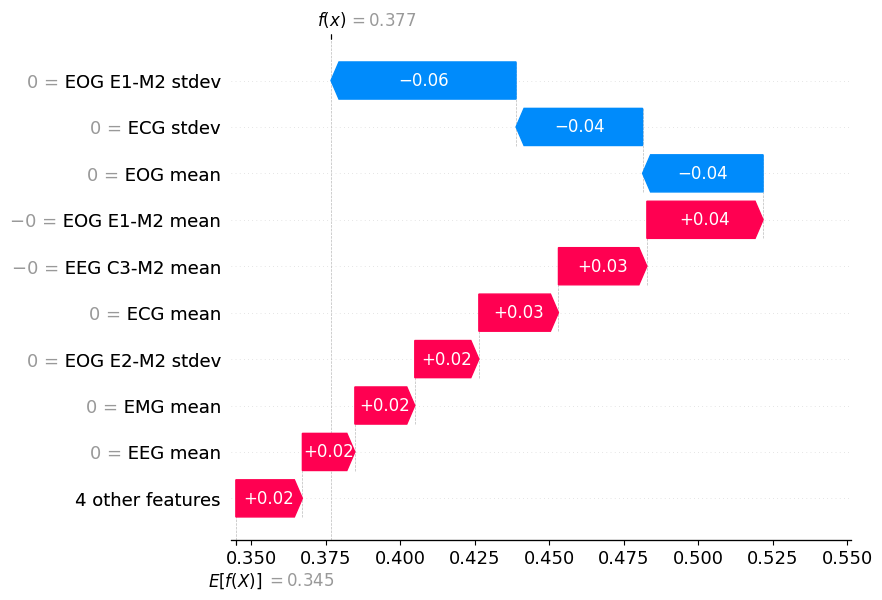

In [11]:
# Generate the SHAP explainer
explainer = shap.Explainer(final_clf, x_selected,
                           feature_names=final_feature_names)

# Apply the SHAP explainer on our dataset
shap_values = explainer(x_selected)

# Find the predicted class for the first sample
target_class = model_classes.index(y_pred[0])
shap.plots.waterfall(shap_values[0, :, target_class])

**(Part 4)** What was the most important feature for this prediction on this sample?

Write your answer here: `EOG E1-M2 stdev`

**(Part 5)** Using `shap.summary_plot()`, generate a plot showing the influence of each feature on the model's prediction for the entire dataset with respect to REM sleep (class `R`).

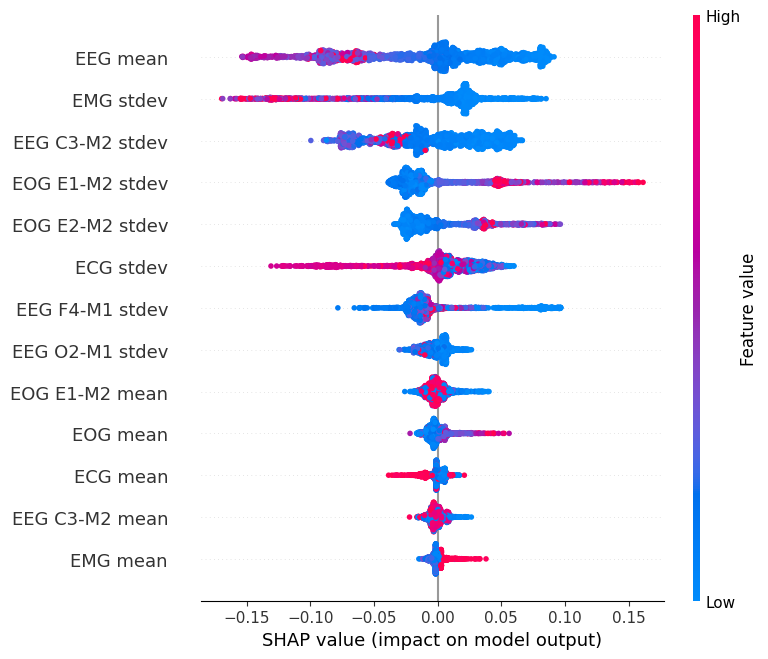

In [12]:
w_class = model_classes.index('R')
shap.summary_plot(shap_values[:, :, w_class], features=x_selected,
                  feature_names=final_feature_names)

**(Part 6)** Which feature(s) were the most positively correlated with positive REM predictions in your model (i.e., higher value led to an `R` prediction)?

Write your answer here: `EOG E1-M2 stdev`

**(Part 7)** Which feature(s) were the most negatively correlated with positive REM predictions in your model (i.e., higher value led to a non-`R` prediction)?

Write your answer here: `EEG Mean`, `EMG Stdev`, `EEG C3-M2 stdev`

# Prepare Submission

To get full credit for this assignment, you should submit your assignment in two formats so that we can easily grade and debug your code:
1. **.ipynb:** First, confirm that your code can run from start to finish without any errors. To check this, go to "Runtime" > "Run all" in the Google Colab menu. If everything looks good, you can export your file by going to "File" > "Download" > "Download .ipynb".
2. **.pdf:** Run the function called `colab2pdf()` below. This will automatically convert your notebook to a PDF. Note that while "File" > "Print" > "Save as PDF" also works, it requires you to manually expand all of the cells and may cut off some images.

In [13]:
colab2pdf()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>